The main point of this work is to try and teach the Q-Learning model to play The Snake game using only the information a human would reseve.

In [13]:
!pip install pygame
# Hello from creator!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import matplotlib.pyplot as plt
from IPython import display
 
import pygame
import random
from enum import Enum
from collections import namedtuple, deque
import numpy as np
from math import sqrt
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

Creating a class that implements the logic of "The Snake" game 

In [15]:
class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

SPEED = 200

In [16]:
class SnakeGameAI:
 
    def __init__(self, w = 200, h = 200, tilesize = 20, offset = 5):
        self.w = w
        self.h = h
        self.ts = tilesize
        self.os = offset
        self.tw = self.w // self.ts
        self.th = self.h // self.ts

        self.reset()
 
 
    def reset(self):
        # game always starts at the same position, \
        # which makes it easiear for agent ot learn
        self.direction = Direction.RIGHT
 
        self.head = Point(self.tw / 2, self.th / 2)
        self.snake = [self.head,
          Point(self.head.x - 1, self.head.y),
          Point(self.head.x - 2, self.head.y)]
 
        self.score = 0
        self.food = None
        self._place_food()
        self.frames = 0
 
    def _place_food(self):
        x = random.randint(0, self.tw - 1)
        y = random.randint(0, self.th - 1)
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()
 
    def play_step(self, action):
        self.frames += 1

        # move
        self._move(action) # update the head
        self.snake.insert(0, self.head)
    
        # check if game over
        reward = -1
        game_over = False
 
        if self.is_collision() == 2:
            game_over = True
            reward = -50
            return reward, game_over, self.score
 
        if self.is_collision() == 1 or self.frames > 100 * len(self.snake):
            game_over = True
            reward = -20
            return reward, game_over, self.score
 
        # place new food or just move
        if self.head == self.food:
            self.score += 1
            reward = 3.5 * sqrt(self.score)
            self._place_food()
        else:
            self.snake.pop()
    

        # return game over and score
        return reward, game_over, self.score
 
 
    def is_collision(self, pt=None):
        if pt is None:
            pt = self.head
        # hits boundary
        if pt.x >= self.tw or pt.x < 0 or pt.y >= self.th or pt.y < 0:
            return 1
        # hits itself
        if pt in self.snake[1:]:
            return 2
 
        return 0 
 
    def _move(self, action):
        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)
 
        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx] # no change
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx] # right turn r -> d -> l -> u
        else: # [0, 0, 1]
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx] # left turn r -> u -> l -> d
 
        self.direction = new_dir
 
        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += 1
        elif self.direction == Direction.LEFT:
            x -= 1
        elif self.direction == Direction.DOWN:
            y += 1
        elif self.direction == Direction.UP:
            y -= 1
 
        self.head = Point(x, y)

Helper function for visualizing metrics

In [17]:
# plotting utility function
 
plt.ion()
 
def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.figure(figsize=(25,10))
    plt.title('Training...')
    plt.xlabel('Number of games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(round(mean_scores[-1],2)))
    plt.show(block=False)
    plt.pause(.1)

Нейронная сеть (DQN) и класс реализующий обучение

In [18]:
class Linear_QNet(nn.Module):
    # very simple network,
    # with only one hidden layer
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
 
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
 
    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)
 
        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
 
    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
 
        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )
 
        # predicted Q values with current state
        pred = self.model(state)
 
        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))
 
            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        # Bellman equation
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()
 
        self.optimizer.step()

Agent playing "The Snake"

In [19]:
MAX_MEMORY = 100000
BATCH_SIZE = 1000
LR = 0.001

In [20]:
class Agent:

    def __init__(self, train = True):
        self.train = train
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_QNet(11, 256, 3)
        if not self.train:
            self.model.load_state_dict(torch.load("model/model.pth"))
            self.model.eval()

        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 1, head.y)
        point_r = Point(head.x + 1, head.y)
        point_u = Point(head.x, head.y - 1)
        point_d = Point(head.x, head.y + 1)

        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Food location 
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
            ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            minibatch = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            minibatch = self.memory

        states, actions, rewards, next_states, dones = zip(*minibatch)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        for state, action, reward, next_state, done in minibatch:
            self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

In [21]:
def train(train = True, episodes = 650):
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent(train)
    game = SnakeGameAI()
    while agent.n_games < episodes:
        # get old state
        state_old = agent.get_state(game)
 
        # get move
        final_move = agent.get_action(state_old)
 
        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)
 
        if  agent.train:
            # train short memory
            agent.train_short_memory(state_old, final_move, reward, state_new, done)
 
            # remember
            agent.remember(state_old, final_move, reward, state_new, done)
 
        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            if agent.train:
                agent.train_long_memory()
            if score > record:
                record = score
                if agent.train:
                    agent.model.save()
 
            print('Game', agent.n_games, 'Score', score, 'Record:', record)
 
            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)
    return agent, plot_scores, plot_mean_scores

In [22]:
os.environ['SDL_VIDEODRIVER']='dummy'
pygame.display.set_mode((640,480));

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

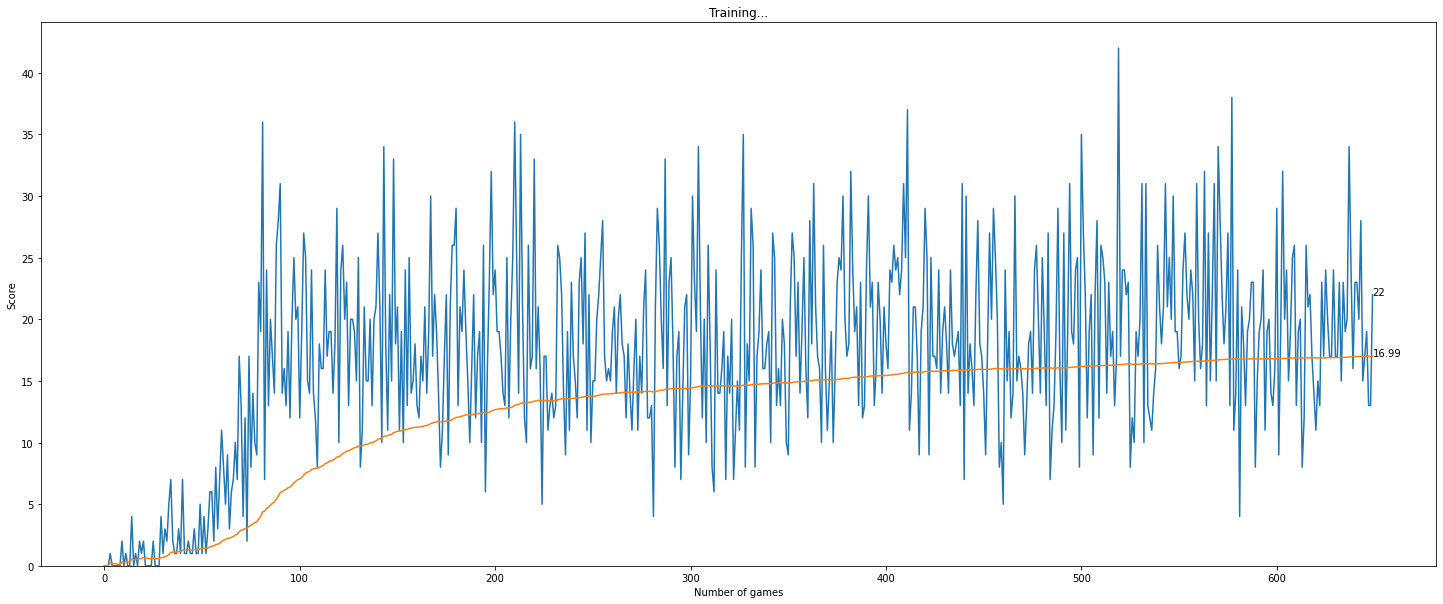

In [23]:
agent, scores, mean_scores = train()

Можно видеть, что после 200 игр, скорость обучения существенно падает.

In [24]:
max(scores)

42